# coPTR comparison
> From read generation to correlation

In [9]:
%load_ext autoreload
%autoreload 2

import aptr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
MAX_MULT = 1
MIN_MULT = -2

# Synthetic data generation
Currently using multipliers from 1E-1 to 1E-4. The 1E-1 files are 5Gb each,
which approaches the limit of what I can shuffle in memory.

This should be run with the `aPTR` conda environment

In [11]:
# %%prun 
# Generate synthetic data
# dd = "../../experiments/synthetic/february2023"
dd = "../../experiments/simulated/october2023"
db = aptr.RnaDB()

! mkdir -p {dd}

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    print(f"Generating fastq_1E{multiplier}")

    # Catch crashes earlier if you iterate down
    try:
        os.mkdir(f"{dd}/fastq_1E{multiplier}")
    except FileExistsError:
        pass

    # Generate data
    abundances, log2_ptrs, otus = aptr.simulation_new.make_tables(
        n_genomes=20,
        n_samples=10,
        db=db,
        sparsity=0.5,
        multiplier=10**multiplier,
        fasta_dir="../../data/seqs",
        fasta_ext=".fna",
        fastq_out_path=f"{dd}/fastq_1E{multiplier}",
        downsample=.01,
        shuffle=False
    )

    # Save abundances, ptrs, otus
    abundances.to_csv(f"{dd}/abundances_1E{multiplier}.tsv", sep="\t")
    log2_ptrs.to_csv(f"{dd}/log2_ptrs_1E{multiplier}.tsv", sep="\t")
    otus.to_csv(f"{dd}/otus_1E{multiplier}.tsv", sep="\t")


0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering
Generating fastq_1E1
Writing Sample_0.fastq
Writing Sample_1.fastq
Writing Sample_2.fastq
Writing Sample_3.fastq
Writing Sample_4.fastq
Writing Sample_5.fastq
Writing Sample_6.fastq
Writing Sample_7.fastq
Writing Sample_8.fastq
Writing Sample_9.fastq
Generating fastq_1E0
Writing Sample_0.fastq
Writing Sample_1.fastq
Writing Sample_2.fastq
Writing Sample_3.fastq
Writing Sample_4.fastq
Writing Sample_5.fastq
Writing Sample_6.fastq
Writing Sample_7.fastq
Writing Sample_8.fastq
Writing Sample_9.fastq
Generating fastq_1E-1
Writing Sample_0.fastq
Writing Sample_1.fastq
Writing Sample_2.fastq
Writing Sample_3.fastq
Writing Sample_4.fastq
Writing Sample_5.fastq
Writing Sample_6.fastq
Writing Sample_7.fastq
Writing Sample_8.fastq
Writing Sample_9.fastq


# Run aPTR

These cells should be executed using the `aPTR` conda environment

In [12]:
for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! ~/aptr/_aptr.py {dd}/fastq_1E{multiplier} "" "" --otu_path {dd}/otus_1E{multiplier}.tsv

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering
Output directory UUID: ../../experiments/simulated/october2023/fastq_1E1/aptr_c20a440b-8870-429e-937b-b522f67cb595
Genomes: ['156889.10', '926569.3', '262768.5', '561230.3', '1267021.3', '313596.4', '164757.10', '983917.3', '1286364.3', '425104.7', '643648.3', '748280.3', '645991.3', '1146883.3', '491915.6', '945021.8', '1211579.3', '880070.3', '387092.6', '196627.14']
Initial:	 -65.82197570800781
/home/phil/mambaforge/envs/aptr/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUD

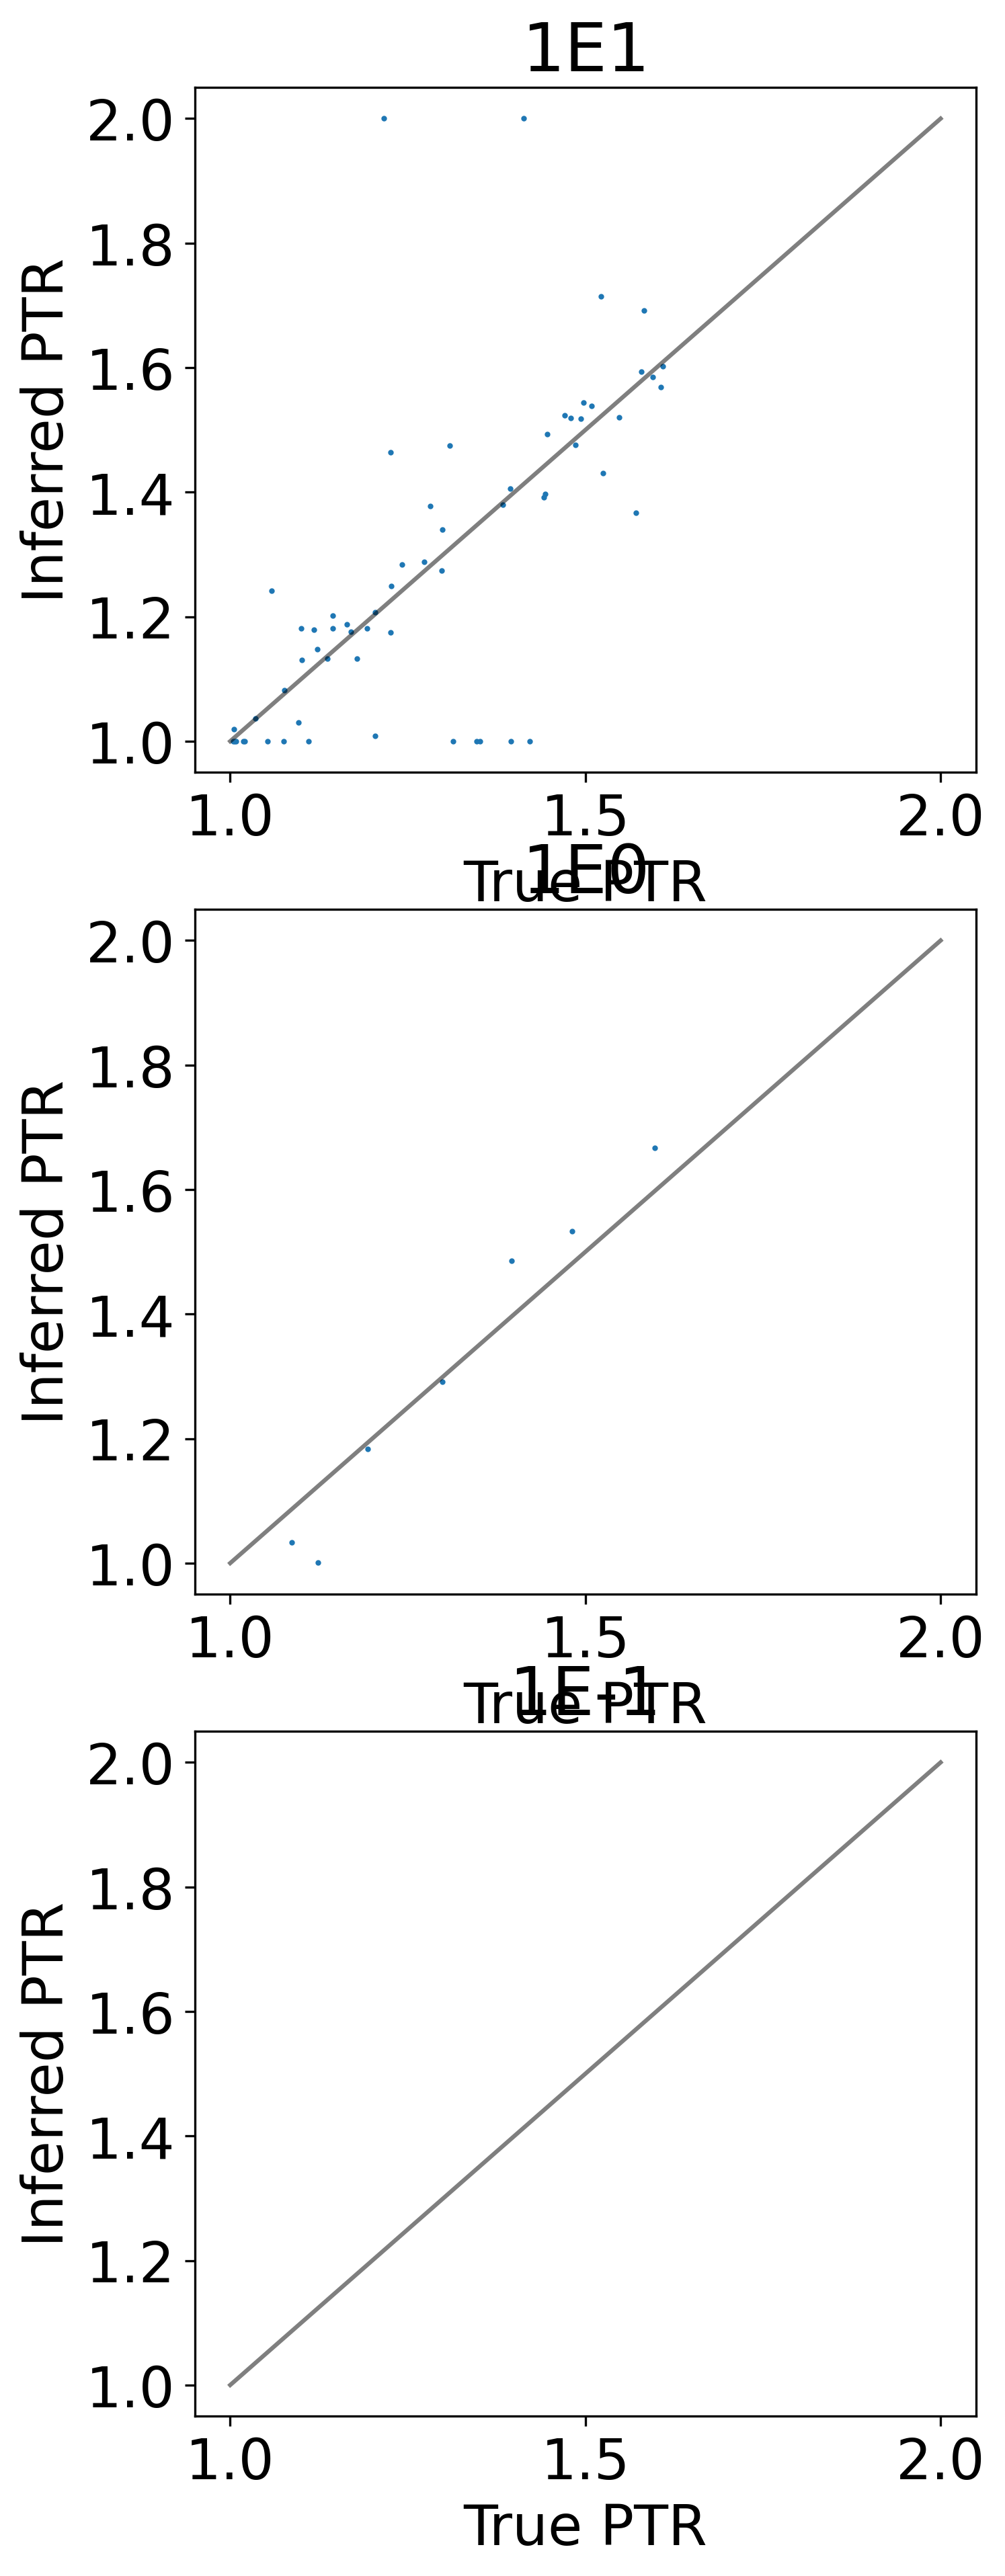

In [13]:
# Are these any good?
fig, axs = plt.subplots(3, 1, figsize=(5, 15))
for i, multiplier in enumerate(range(MAX_MULT, MIN_MULT, -1)):
    # Idempotent directory move
    ! mv {dd}/fastq_1E{multiplier}/aptr_* {dd}/fastq_1E{multiplier}/aptr_results
    
    aptr_results = pd.read_csv(f"{dd}/fastq_1E{multiplier}/aptr_results/inferred_ptrs.tsv", sep="\t", dtype={0: str})
    aptr_results = aptr_results.set_index(aptr_results.columns[0])

    true_ptrs = pd.read_csv(f"{dd}/log2_ptrs_1E{multiplier}.tsv", sep="\t", dtype={0: str})
    true_ptrs = true_ptrs.set_index(true_ptrs.columns[0])
    true_ptrs = 2**true_ptrs

    # Compare
    aptr_results = aptr_results.loc[true_ptrs.index]
    true_ptrs = true_ptrs.loc[aptr_results.index]

    # Plot
    axs[i].scatter(true_ptrs, aptr_results, s=1)
    axs[i].set_title(f"1E{multiplier}")
    axs[i].set_xlabel("True PTR")
    axs[i].set_ylabel("Inferred PTR")
    axs[i].plot([1, 2], [1, 2], c="k", alpha=.5)


# Run coPTR
These cells must be executed with the `coptr` conda environment

In [21]:
# ! conda install -n coptr ipykernel --update-deps --force-reinstall
import pandas as pd

# dd = "../../experiments/synthetic/february2023"
dd = "../../experiments/simulated/october2023"
MAX_MULT = 1
MIN_MULT = -2

In [22]:
# Step 1: Get all of the FASTA files we used and make an index

genomes = set()
for multiplier in range(MAX_MULT, MIN_MULT, -1):
    genomes |= set(pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str}).iloc[:,0])

print(genomes)

! mkdir -p {dd}/coptr
! mkdir -p {dd}/coptr/seqs
! mkdir -p {dd}/coptr/index
for genome in genomes:
    ! cp ../../data/seqs/{genome}.fna {dd}/coptr/seqs

! /home/phil/mambaforge/envs/coptr/bin/coptr index {dd}/coptr/seqs {dd}/coptr/index/seqs

{'765952.4', '406818.4', '387092.6', '243265.5', '880478.3', '196627.14', '983917.3', '264199.4', '384676.9', '1407647.3', '1267021.3', '584708.3', '1346.30', '573062.4', '164757.10', '550540.3', '262768.5', '481743.5', '743973.3', '1131462.4', '637905.5', '632518.3', '425104.7', '880070.3', '279113.9', '643648.3', '213554.3', '479435.6', '319225.5', '505682.4', '399726.7', '44742.4', '748280.3', '1146883.3', '491915.6', '1162668.3', '649639.5', '386415.7', '1349767.4', '313596.4', '195103.10', '945021.8', '1286364.3', '1211579.3', '484770.3', '1247649.3', '645991.3', '742013.3', '926569.3', '156889.10', '243276.5', '1305737.4', '61647.10', '655815.4', '216142.3', '1301098.3', '561230.3'}
[INFO] [Oct 28, 2023 13:10:32] [coptr.read_mapper] Found 57 files totaling 0.212 GB.
[INFO] [Oct 28, 2023 13:10:32] [coptr.read_mapper] Copying FASTA files to coptr-fna-2023-10-28T17:10:32+00:00.fna with prepended genome ids (filenames).
[INFO] [Oct 28, 2023 13:10:33] [coptr.read_mapper] Writing 57 re

In [23]:
# Step 2: run coPTR on each directory of FASTQ files

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! mkdir -p {dd}/coptr/bam_1E{multiplier}
    ! /home/phil/mambaforge/envs/coptr/bin/coptr map {dd}/coptr/index/seqs {dd}/fastq_1E{multiplier} {dd}/coptr/bam_1E{multiplier} --threads 12

[INFO] [Oct 28, 2023 13:10:35] [coptr.read_mapper] Mapping ../../experiments/simulated/october2023/fastq_1E1 to ../../experiments/simulated/october2023/coptr/bam_1E1/Sample_0.sam
[INFO] [Oct 28, 2023 13:10:35] [coptr.read_mapper] bowtie2 -x ../../experiments/simulated/october2023/coptr/index/seqs ../../experiments/simulated/october2023/fastq_1E1/Sample_0.fastq --no-unal -p 12 -k 10
Traceback (most recent call last):
  File "/home/phil/mambaforge/envs/coptr/bin/coptr", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/home/phil/mambaforge/envs/coptr/lib/python3.12/site-packages/coptr/cli.py", line 576, in cli
    ProgramOptions()
  File "/home/phil/mambaforge/envs/coptr/lib/python3.12/site-packages/coptr/cli.py", line 70, in __init__
    getattr(self, args.command)()
  File "/home/phil/mambaforge/envs/coptr/lib/python3.12/site-packages/coptr/cli.py", line 157, in map
    read_mapper.map(
  File "/home/phil/mambaforge/envs/coptr/lib/python3.12/site-packages/coptr/read_m

In [24]:
# Step 3: extract coverage maps

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! mkdir -p {dd}/coptr/coverage_maps_1E{multiplier}
    ! /home/phil/mambaforge/envs/coptr/bin/coptr extract {dd}/coptr/bam_1E{multiplier} {dd}/coptr/coverage_maps_1E{multiplier}

[INFO] [Oct 28, 2023 13:10:41] [coptr.cli] Found 0 reference sequences corresponding to 0 genomes.
[INFO] [Oct 28, 2023 13:10:42] [coptr.cli] Found 0 reference sequences corresponding to 0 genomes.
[INFO] [Oct 28, 2023 13:10:44] [coptr.cli] Found 0 reference sequences corresponding to 0 genomes.


In [25]:
# Step 4: get PTRs

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! /home/phil/mambaforge/envs/coptr/bin/coptr estimate {dd}/coptr/coverage_maps_1E{multiplier} {dd}/coptr/coptr_1E{multiplier}.csv

[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] Grouping reads by reference genome.
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] Saving to ../../experiments/simulated/october2023/coptr/coverage_maps_1E1/coverage-maps-genome:
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] Grouping by reference genome: Complete.
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] The --restart flag can be used to start from here.
[INFO] [Oct 28, 2023 13:10:45] [coptr.coptr_ref] Checking reference genomes.
[INFO] [Oct 28, 2023 13:10:45] [coptr.coptr_contig] Checking reference genomes.
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] Writing ../../experiments/simulated/october2023/coptr/coptr_1E1.csv.
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] Done.
[INFO] [Oct 28, 2023 13:10:45] [coptr.cli] You may now remove the folder ../../experiments/simulated/october2023/coptr/coverage_maps_1E1/coverage-maps-genome.
[INFO] [Oct 28, 2023 13:10:47] [coptr.cli] Grouping reads by reference genome.
[INFO] [Oct 28, 2023 13:10:47] [coptr.cli] Saving

In [26]:
# Step 5: get read counts as well

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! /home/phil/mambaforge/envs/coptr/bin/coptr count {dd}/coptr/coverage_maps_1E{multiplier} {dd}/coptr/coptr_counts_1E{multiplier}.csv

[INFO] [Oct 28, 2023 13:10:49] [coptr.cli] Computing read counts.
[INFO] [Oct 28, 2023 13:10:49] [coptr.cli] Writing ../../experiments/simulated/october2023/coptr/coptr_counts_1E1.csv.
[INFO] [Oct 28, 2023 13:10:49] [coptr.cli] Done.
[INFO] [Oct 28, 2023 13:10:50] [coptr.cli] Computing read counts.
[INFO] [Oct 28, 2023 13:10:50] [coptr.cli] Writing ../../experiments/simulated/october2023/coptr/coptr_counts_1E0.csv.
[INFO] [Oct 28, 2023 13:10:50] [coptr.cli] Done.
[INFO] [Oct 28, 2023 13:10:51] [coptr.cli] Computing read counts.
[INFO] [Oct 28, 2023 13:10:51] [coptr.cli] Writing ../../experiments/simulated/october2023/coptr/coptr_counts_1E-1.csv.
[INFO] [Oct 28, 2023 13:10:51] [coptr.cli] Done.


# Compare performance of aPTR and coPTR

Run using the `aPTR` conda environment

(13, 10) (13, 10) (13, 10)
(20, 10) (20, 10) (20, 10)
(20, 10) (20, 10) (20, 10)


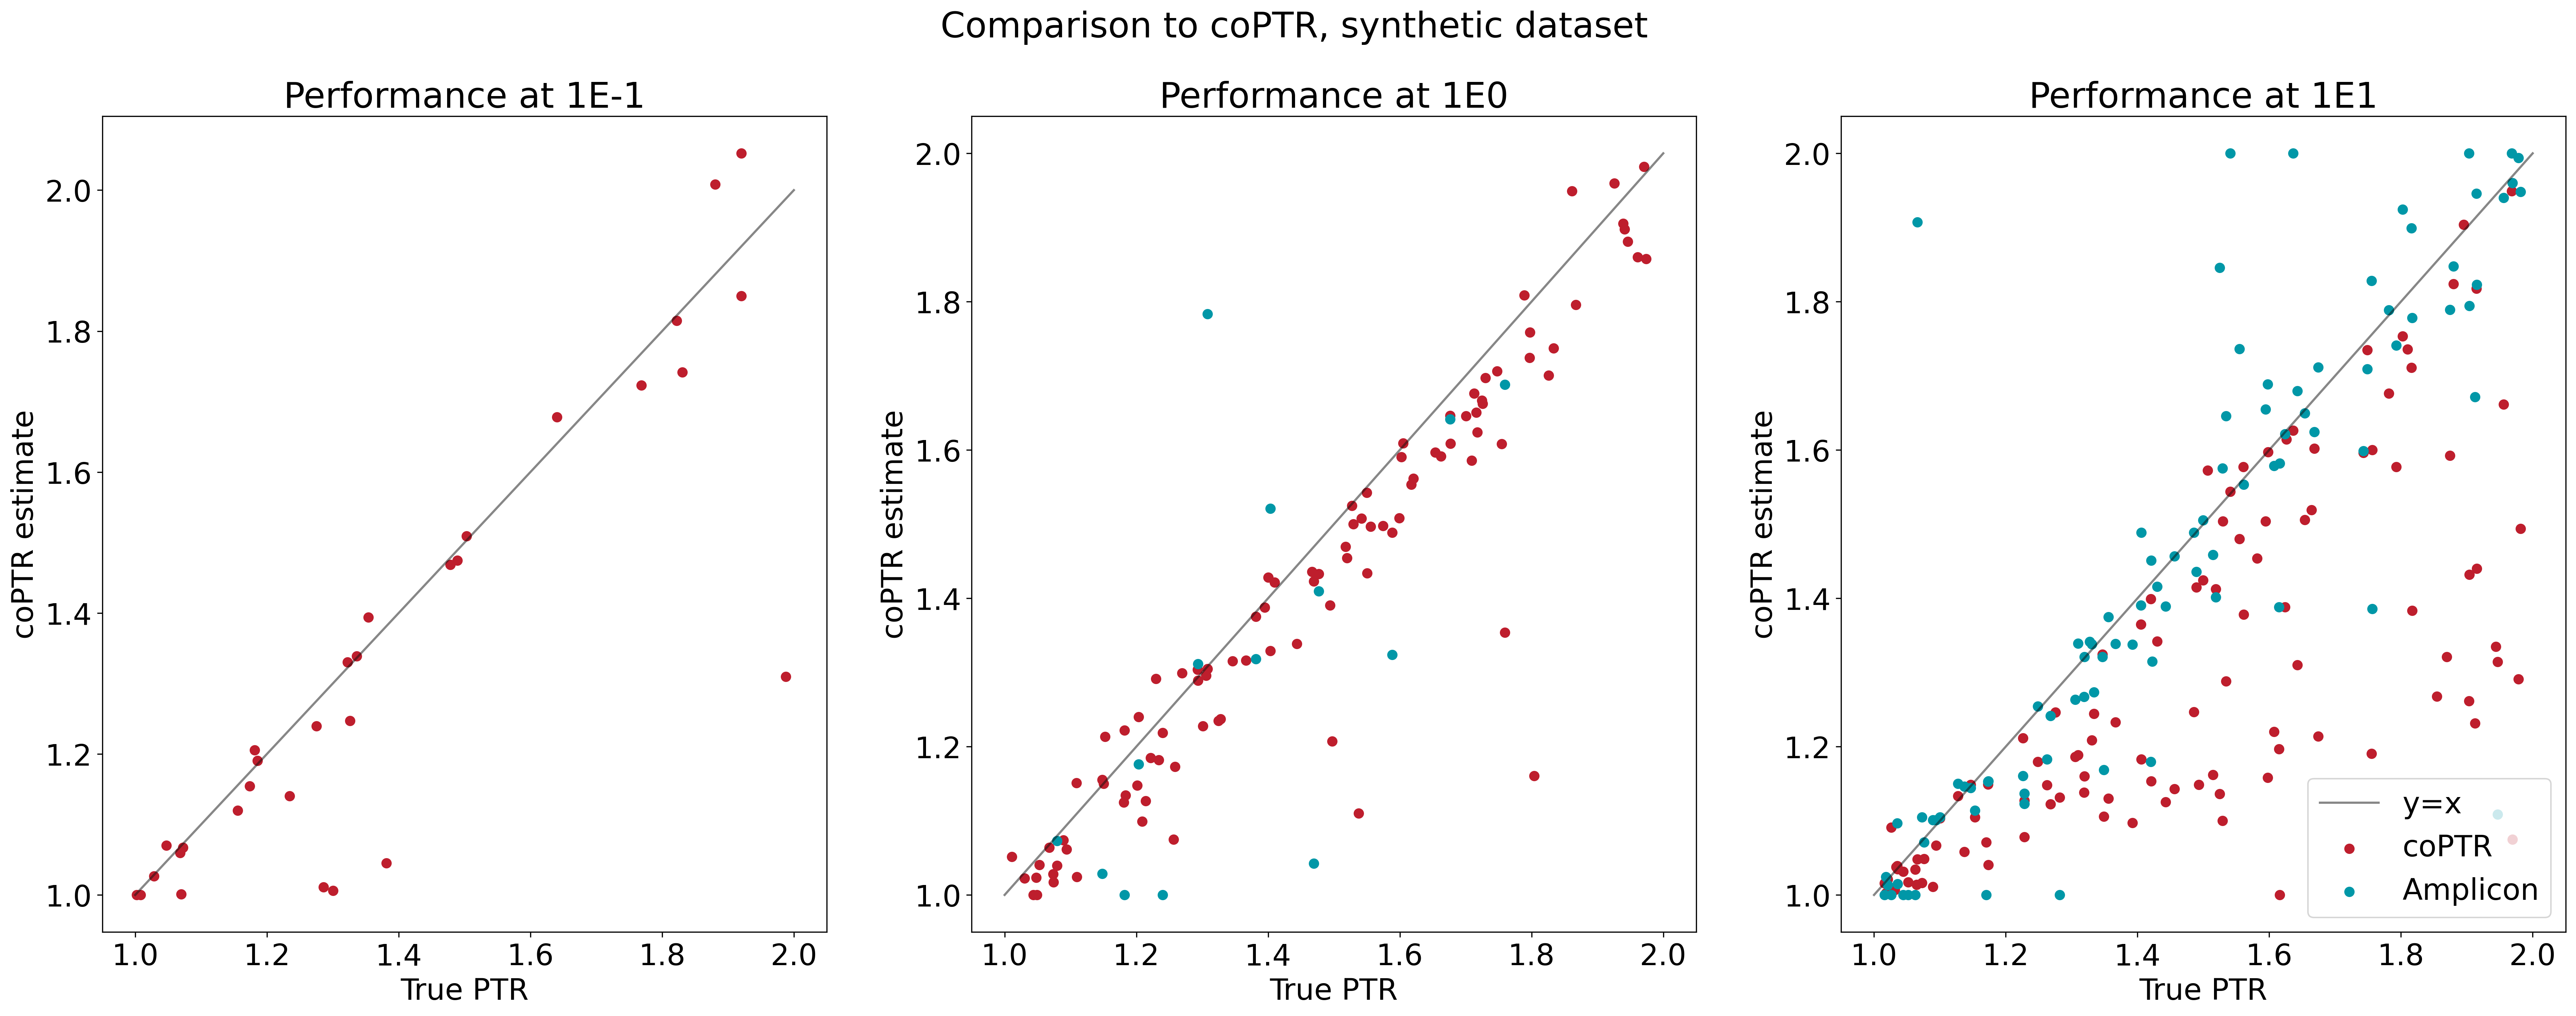

In [29]:
# Load PTR data, coPTR estimates, and aPTR estimates and compare

plt.rc("font", size=20)

dd = "../../experiments/simulated/february2023"
# dd = "../../experiments/simulated/october2023"
MAX_MULT = 2
MIN_MULT = -1
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for multiplier, ax in zip(range(MIN_MULT, MAX_MULT, 1), axs):
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})
    true_ptrs = true_ptrs.set_index(true_ptrs.columns[0])
    true_ptrs = 2**true_ptrs

    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_1E{multiplier}.csv", dtype={0: str})
    coptr_estimate = coptr_estimate.set_index(coptr_estimate.columns[0])
    coptr_estimate = 2**coptr_estimate

    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/inferred_ptrs.tsv", dtype={0: str})
    aptr_estimate = aptr_estimate.set_index(aptr_estimate.columns[0])

    # Reindex to shared OTUs
    true_ptrs = true_ptrs.reindex(set(coptr_estimate.index) & set(aptr_estimate.index))
    coptr_estimate = coptr_estimate.loc[true_ptrs.index]
    aptr_estimate = aptr_estimate.loc[true_ptrs.index]

    print(true_ptrs.shape, coptr_estimate.shape, aptr_estimate.shape)

    # Non-NA for all
    ax.plot([1, 2], [1, 2], c="#111111", alpha=0.5)
    ax.scatter(true_ptrs.values, coptr_estimate.values, c="#BE1E2D")
    ax.scatter(true_ptrs.values, aptr_estimate.values, c="#0097A7")
    ax.set_xlabel("True PTR")
    ax.set_ylabel("coPTR estimate")
    ax.set_title(f"Performance at 1E{multiplier}")

plt.legend(["y=x", "coPTR", "Amplicon"], loc="lower right")
plt.suptitle("Comparison to coPTR, synthetic dataset")
plt.show()

                 1_0       1_1       1_2       1_3       1_4       1_5  \
Unnamed: 0                                                               
1042156.4  -0.109508       NaN       NaN -0.026272       NaN       NaN   
37659.3          NaN  0.055779 -0.105364       NaN -0.028277       NaN   
479436.6   -0.002553       NaN       NaN -0.013962       NaN       NaN   
759620.7   -0.053851       NaN  0.083443       NaN  0.079944  0.013734   
818.23           NaN -0.188725 -0.051863  0.000796  0.037460 -0.053356   
267747.3    0.470207  0.493239       NaN -0.226975  0.459027       NaN   
592031.3         NaN       NaN       NaN       NaN -0.051571       NaN   
637905.5         NaN -0.006304  0.037072 -0.015511 -0.033510       NaN   
759620.6   -0.107434       NaN       NaN  0.104908       NaN -0.026075   
1262449.8        NaN       NaN -0.039202 -0.036114  0.011563       NaN   
1392490.5  -0.179946  0.096519  0.483317  0.072508 -0.240958       NaN   
1379870.5  -0.091185 -0.038848 -0.0791

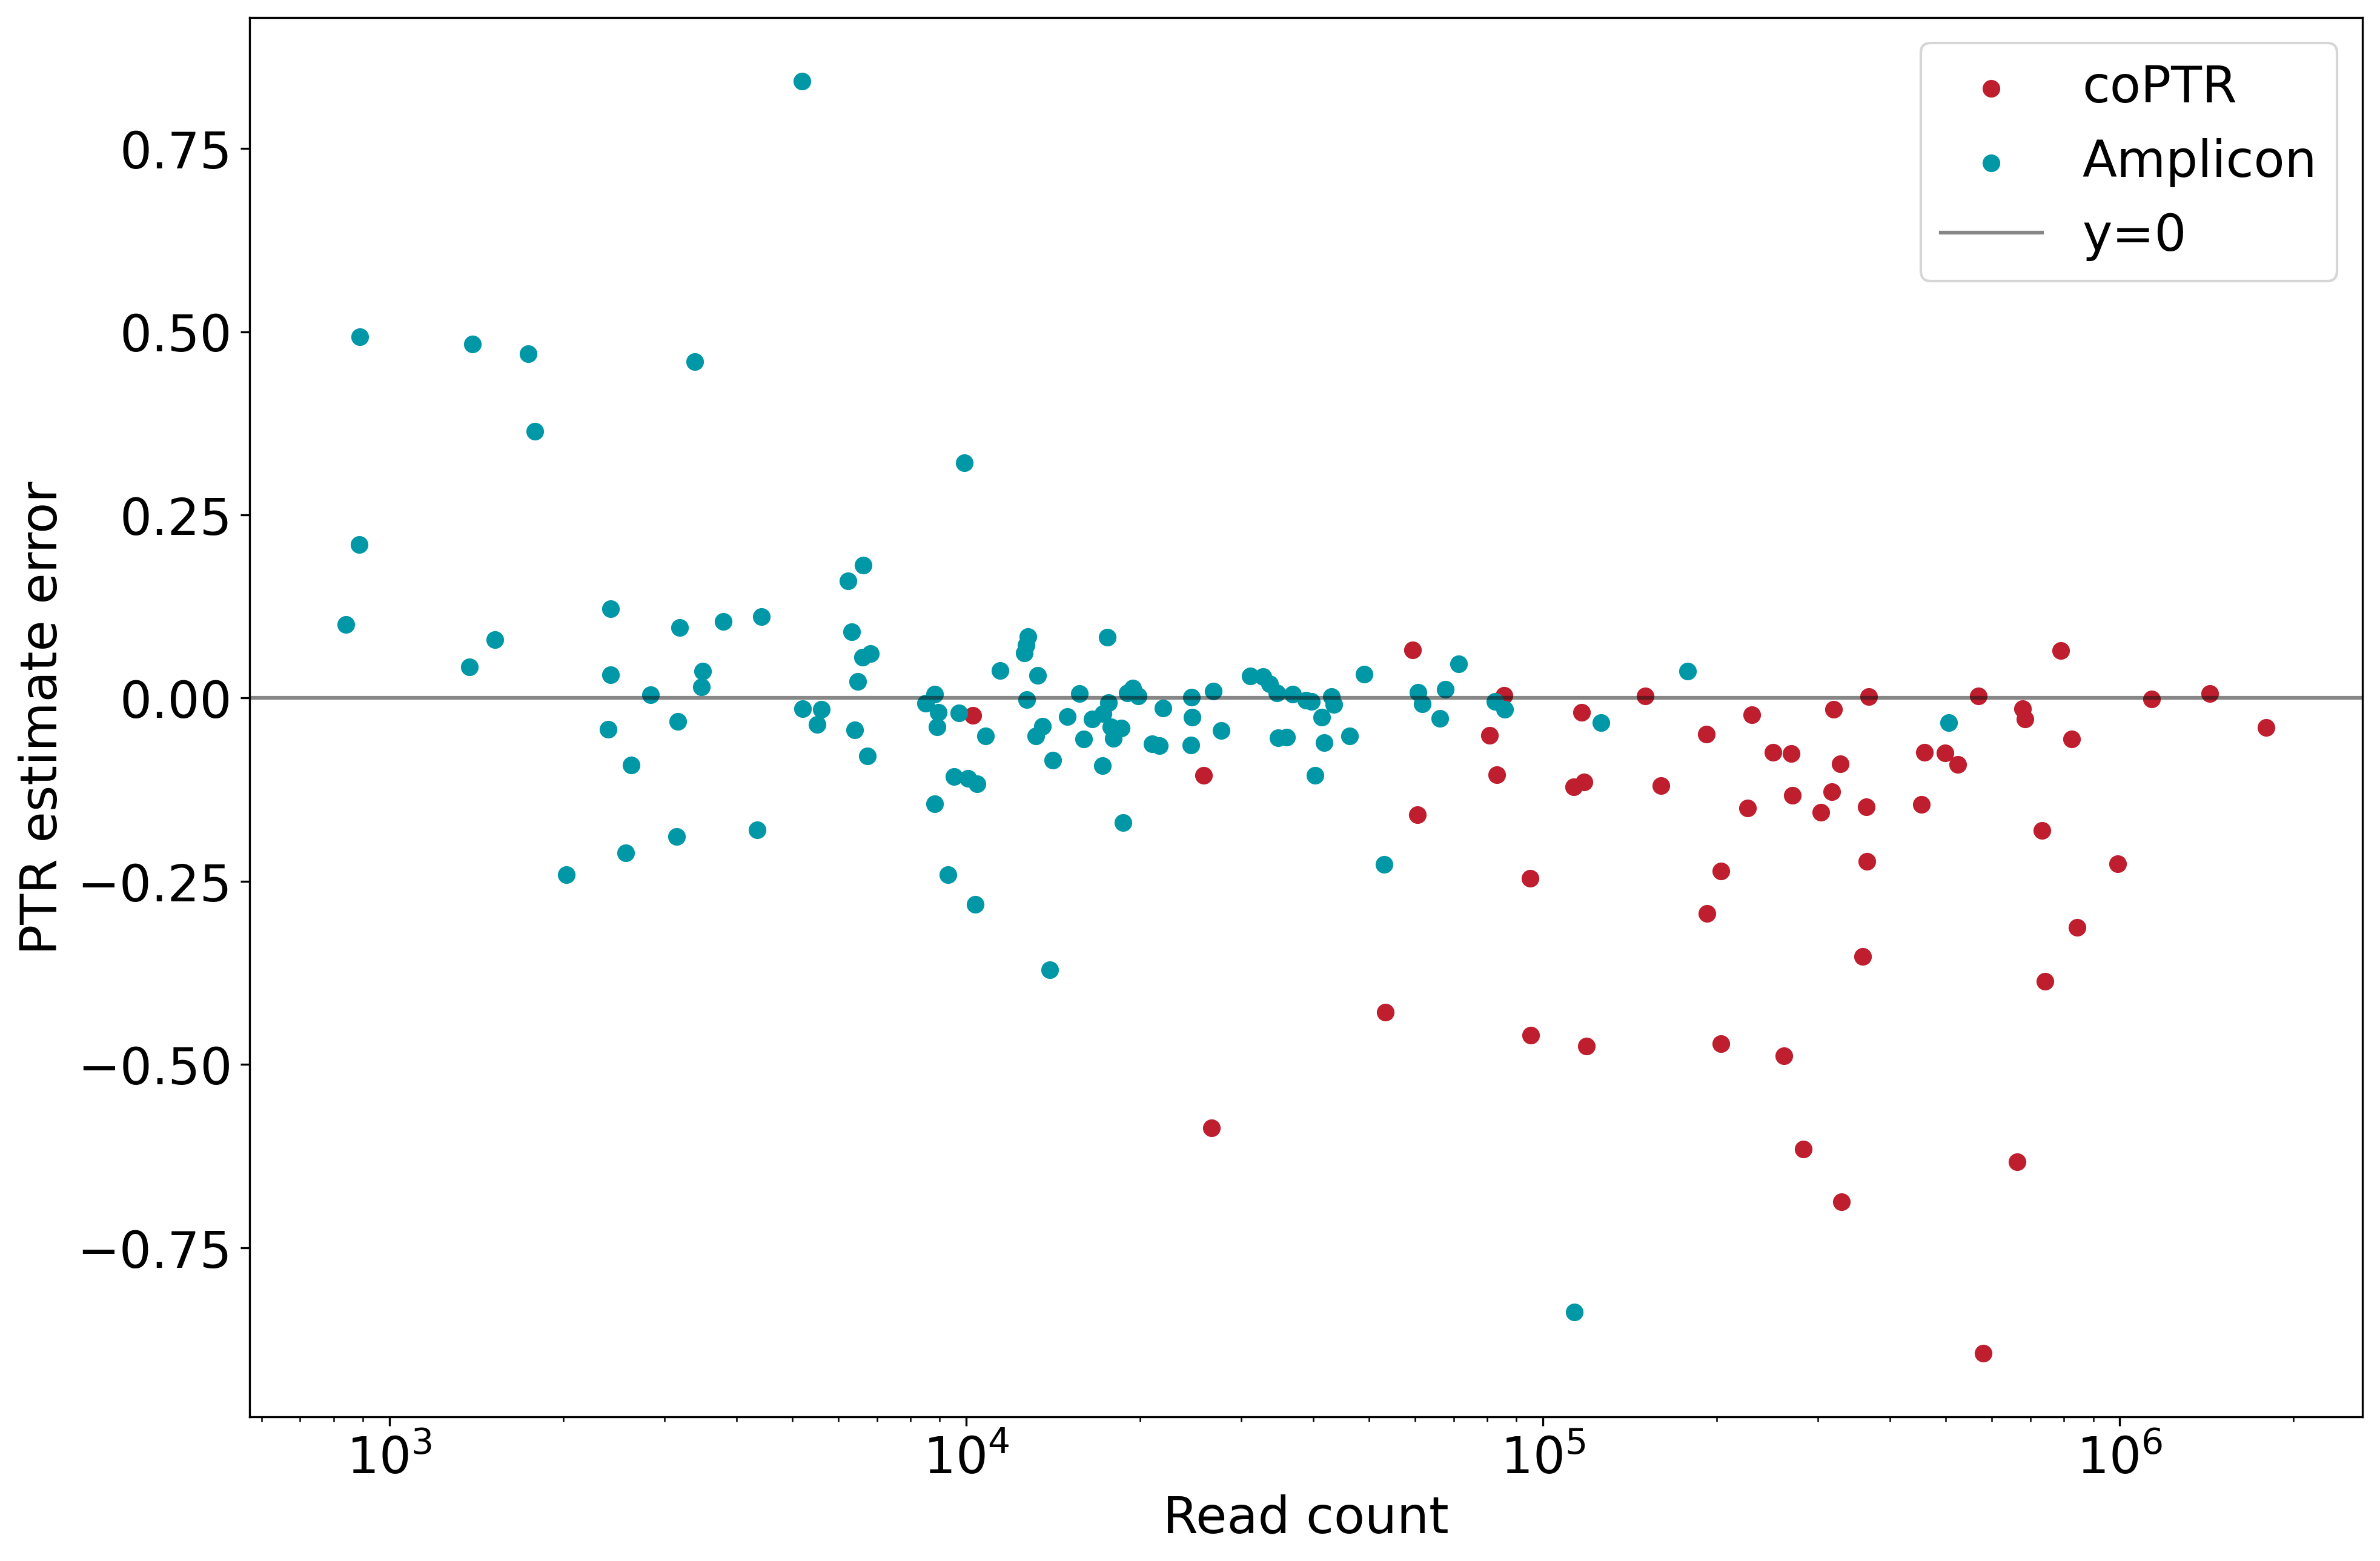

In [31]:
# Accuracy vs. number of reads
from aptr import RnaDB
import pickle

coptr_counts_all = pd.DataFrame()
coptr_errors_all = pd.DataFrame()
aptr_counts_all = pd.DataFrame()
aptr_errors_all = pd.DataFrame()

for multiplier in range(MIN_MULT + 2, MAX_MULT, 1):
    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_all_1E{multiplier}.csv", dtype={0: str})
    coptr_counts = pd.read_csv(f"{dd}/coptr/coptr_counts_1E{multiplier}.csv", dtype={0: str})
    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/all_inferred_ptrs.tsv", dtype={0: str})
    otus = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/filtered_otu_table.tsv", dtype={0: str})
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})

    for df in [coptr_estimate, coptr_counts, aptr_estimate, otus, true_ptrs]:
        df.set_index(df.columns[0], inplace=True)

    coptr_estimate = 2**coptr_estimate
    true_ptrs = 2**true_ptrs

    # Rename columns for coPTR dfs
    coptr_estimate.columns = coptr_counts.columns = aptr_estimate.columns = otus.columns = true_ptrs.columns = [
        f"{multiplier}_{x}" for x in range(10)
    ]

    # Get errors
    idx1 = set(coptr_estimate.index) & set(true_ptrs.index)
    coptr_errors = coptr_estimate.reindex(idx1) - true_ptrs.reindex(idx1)
    idx2 = set(aptr_estimate.index) & set(true_ptrs.index)
    aptr_errors = aptr_estimate.reindex(idx2) - true_ptrs.reindex(idx2)
    print(aptr_errors)

    # Getting read counts for aPTR is tricky - we need to sum over the OTUs
    # with open(f"{dd}/fastq_1E{multiplier}/aptr_results/db.pkl", "rb") as f:
        # db = pickle.load(f)
    db = RnaDB() # Workaround
    aptr_counts = pd.DataFrame(0, index=aptr_errors.index, columns=aptr_errors.columns)
    for otu in otus.index:
        genomes = db.find_genomes_by_md5(otu)

        # Can add whole rows at once
        for genome in genomes:
            aptr_counts.loc[genome] += otus.loc[otu]

    # Append all as columns
    coptr_counts_all = pd.concat([coptr_counts_all, coptr_counts], axis=1)
    coptr_errors_all = pd.concat([coptr_errors_all, coptr_errors], axis=1)
    aptr_counts_all = pd.concat([aptr_counts_all, aptr_counts], axis=1)
    aptr_errors_all = pd.concat([aptr_errors_all, aptr_errors], axis=1)

# Matplotlib stuff is straightforward
fig = plt.figure(figsize=(15, 10))
plt.scatter(coptr_counts_all, coptr_errors_all, c="#BE1E2D", label="coPTR")
plt.scatter(aptr_counts_all, aptr_errors_all, c="#0097A7", label="Amplicon")
plt.axhline(0, c="#111111", alpha=0.5, label="y=0")
plt.xlabel("Read count")
plt.ylabel("PTR estimate error")

plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()